# Supervised Learning Regression

This notebook compares multiple regression models with PCA preprocessing.

In [1]:

import numpy as np
import pandas as pd
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:

X, y = load_diabetes(return_X_y=True, as_frame=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
numeric_features = X.columns
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=0.95, random_state=42))
])
preprocessor = ColumnTransformer(
    transformers=[('num', numeric_transformer, numeric_features)]
)


In [3]:

dummy = Pipeline(steps=[('preprocessor', preprocessor), ('model', DummyRegressor())])
dummy.fit(X_train, y_train)
y_pred = dummy.predict(X_test)
baseline_metrics = {
    'MAE': mean_absolute_error(y_test, y_pred),
    'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
    'R2': r2_score(y_test, y_pred)
}
baseline_metrics


{'MAE': 64.00646146990485,
 'RMSE': np.float64(73.22249283682244),
 'R2': -0.011962984778542296}

In [4]:

models = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(alpha=1.0, random_state=42),
    "Lasso": Lasso(alpha=0.1, random_state=42, max_iter=10000),
    "ElasticNet": ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42, max_iter=10000),
    "SVR": SVR(kernel='rbf', C=1.0, epsilon=0.2),
    "KNeighbors": KNeighborsRegressor(n_neighbors=5),
    "RandomForest": RandomForestRegressor(n_estimators=100, random_state=42),
    "GradientBoosting": GradientBoostingRegressor(random_state=42)
}
cv = KFold(n_splits=5, shuffle=True, random_state=42)
results = []
for name, model in models.items():
    pipe = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])
    scores = {'model': name}
    scores['cv_mae'] = -cross_val_score(pipe, X_train, y_train, cv=cv, scoring='neg_mean_absolute_error').mean()
    scores['cv_rmse'] = np.sqrt(-cross_val_score(pipe, X_train, y_train, cv=cv, scoring='neg_mean_squared_error').mean())
    scores['cv_r2'] = cross_val_score(pipe, X_train, y_train, cv=cv, scoring='r2').mean()
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    scores['test_mae'] = mean_absolute_error(y_test, y_pred)
    scores['test_rmse'] = np.sqrt(mean_squared_error(y_test, y_pred))
    scores['test_r2'] = r2_score(y_test, y_pred)
    results.append(scores)
results_df = pd.DataFrame(results)
results_df


,model,cv_mae,cv_rmse,cv_r2,test_mae,test_rmse,test_r2
0,LinearRegression,45.040739,55.569169,0.477837,42.915647,53.697589,0.455767
1,Ridge,45.038661,55.562765,0.477974,42.913321,53.687811,0.455965
2,Lasso,45.040236,55.562891,0.477918,42.911692,53.675843,0.456207
3,ElasticNet,45.077622,55.515443,0.479089,42.934773,53.548851,0.458777
4,SVR,61.007516,73.076080,0.105220,55.980169,65.726576,0.184625
5,KNeighbors,48.978946,62.281077,0.343857,41.804494,54.279191,0.443914
6,RandomForest,47.892043,59.302638,0.405327,42.134719,52.898787,0.471838
7,GradientBoosting,47.173267,59.847012,0.390913,42.422781,53.277499,0.464249


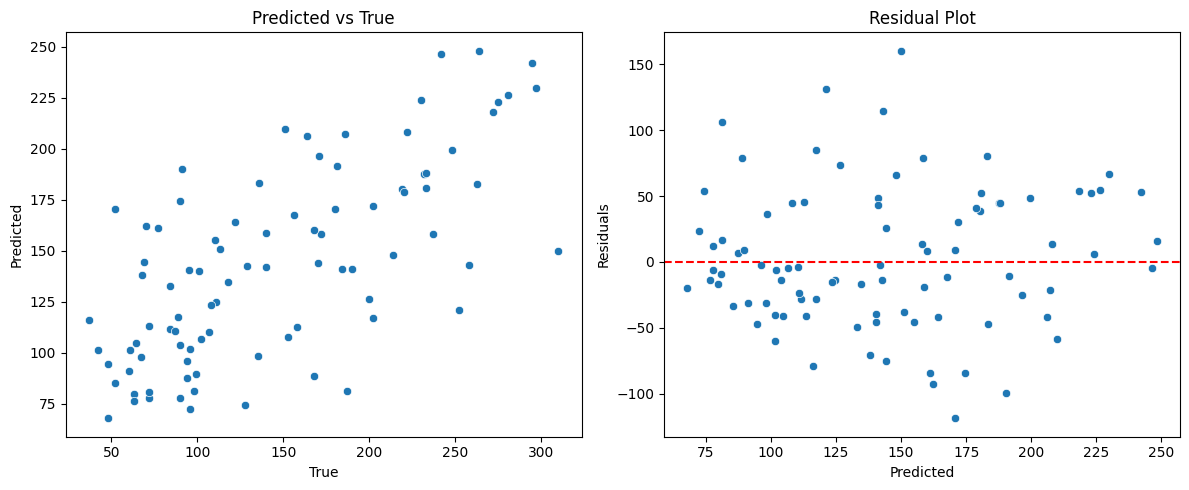

In [5]:

best_model_name = results_df.sort_values('test_rmse').iloc[0]['model']
best_model = models[best_model_name]
pipe = Pipeline(steps=[('preprocessor', preprocessor), ('model', best_model)])
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
residuals = y_test - y_pred
fig, axes = plt.subplots(1,2, figsize=(12,5))
sns.scatterplot(x=y_test, y=y_pred, ax=axes[0])
axes[0].set_xlabel("True")
axes[0].set_ylabel("Predicted")
axes[0].set_title("Predicted vs True")
sns.scatterplot(x=y_pred, y=residuals, ax=axes[1])
axes[1].axhline(0, color='red', linestyle='--')
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Residuals")
axes[1].set_title("Residual Plot")
plt.tight_layout()
plt.show()


In [6]:

results_df.sort_values('test_rmse')


,model,cv_mae,cv_rmse,cv_r2,test_mae,test_rmse,test_r2
6,RandomForest,47.892043,59.302638,0.405327,42.134719,52.898787,0.471838
7,GradientBoosting,47.173267,59.847012,0.390913,42.422781,53.277499,0.464249
3,ElasticNet,45.077622,55.515443,0.479089,42.934773,53.548851,0.458777
2,Lasso,45.040236,55.562891,0.477918,42.911692,53.675843,0.456207
1,Ridge,45.038661,55.562765,0.477974,42.913321,53.687811,0.455965
0,LinearRegression,45.040739,55.569169,0.477837,42.915647,53.697589,0.455767
5,KNeighbors,48.978946,62.281077,0.343857,41.804494,54.279191,0.443914
4,SVR,61.007516,73.076080,0.105220,55.980169,65.726576,0.184625
